In [1]:
import numpy as np
from scipy.integrate import odeint
import cobra
import os
from os.path import join
data_dir="."
model=cobra.io.read_sbml_model("iCac802.xml")
import matplotlib.pyplot as plt

No handlers could be found for logger "cobra.io.sbml"
cobra\core\reaction.py:437 UserWarning: uppercase AND/OR found in rule 'CAC0368 AND CAC1427' for '<Reaction R0095 at 0x18634b70>'


In [2]:
solution = model.optimize()

model.summary()

IN FLUXES            OUT FLUXES             OBJECTIVES
-------------------  ---------------------  -------------
cpd00027_e  10       cpd11640_e  37.5       Biomass  0.21
cpd00067_e  10       cpd00011_e  25.6
cpd00001_e   4.05    cpd00178_e   8.65
cpd00013_e   2.94    cpd00528_e   0.541
cpd00009_e   0.373   cpd00036_e   0.000947
cpd00048_e   0.0217


In [3]:
def kineticBlock(Glu,But):
    # Parameters
    vGmax, K_Glu, Ki, Kii = 0.26, 46, 55.6, 67.5
    f_But,f_Act, f_Bth, f_Acn, F_H2 = .424, .908, .977, .908, 0.098
    
    v_Glu=vGmax*Glu/(K_Glu+(Glu/Ki)+Glu*(1+(Bth/Kii)))
    LB_But = -v_Glu*f_But
    LB_Act = -v_Glu*f_Act
    LB_Bth = -v_Glu*f_Bth
    LB_Acn = -v_Glu*f_Acn
    LB_H2 = -v_Glu*F_H2
    #LB_ATP_Ex = m_ATP
    return [v_Glu,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2]

# Metabolic block
def metabolicBlock(v_Glu,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2):
    model.reactions.get_by_id("Ex_91").lower_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("Ex_91").upper_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("Ex_96").lower_bound   = LB_But #Butirato
    model.reactions.get_by_id("Ex_104").lower_bound   = LB_Act #acetato
    model.reactions.get_by_id("Ex_113").lower_bound    = LB_Bth #Butanol
    model.reactions.get_by_id("Ex_110").lower_bound = LB_Acn #Acetona
    model.reactions.get_by_id("Ex_116").lower_bound = LB_H2 #Hidrogeno
   
    solution = model.optimize()
    u = solution.objective_value
    v_But = model.reactions.get_by_id("Ex_96").x
    v_Act = model.reactions.get_by_id("Ex_104").x
    v_Bth = model.reactions.get_by_id("Ex_113").x
    v_Acn = model.reactions.get_by_id("Ex_110").x
    v_H2 = model.reactions.get_by_id("Ex_116").x
    return [u, v_But, v_Act, v_Bth, v_Acn, v_H2]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VBut,VAct,VBth,VAcn,VH2 = y # Current values
    F,u, v_Glu, v_But, v_Act, v_Bth, v_Acn, v_H2 = params  # unpack parameters
    Glu_F = 8
    MW_Glu,MW_But,MW_Act,MW_Bth,MW_Acn, MW_H2 = [0.18,.046,.060,.72,.090, 0.002] #Molecular weights
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_But*MW_But*(VX), # dVBut/dt
            v_Act*MW_Act*(VX), # dVAct/dt
            v_Bth*MW_Bth*(VX), # dVBth/dt
            v_Acn*MW_Acn*(VX), # dVAcn/dt
            v_H2*MW_H2*(VX)] # dVH2/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
 
    soln = odeint(f,y,time,args=(params,))
    
    V=soln[-1,0]
    X,Glu,But,Act,Bth,Acn,H2=soln[-1,1:8]/V
    return [V,X,Glu,But,Act,Bth,Acn,H2]    



u_path,V_path,X_path = [],[],[]
Glu_path,But_path,Act_path,Bth_path,Acn_path,H2_path = [],[],[],[],[],[]
v_Glu_path=[]
def savePath(u,V,X,Glu,But,Act,Bth,Acn,H2,v_Glu):
    global u_path,V_path,X_path
    global Glu_path,But_path,Act_path,Bth_path,Acn_path,H2_path
    global v_Glu_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    But_path += [But]
    Act_path += [Act]
    Bth_path += [Bth]
    Acn_path += [Acn]
    H2_path += [H2]
    v_Glu_path += [v_Glu]

In [4]:
Glu=60
But,Act,Bth,Acn,H2=[0,0,0,0,0]
V,X=[2,1.5]
F=0
# Running the simulation over time
time=np.linspace(0,300,50)
for i in range(len(time)):
    
    v_Glu,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2 = kineticBlock(Glu,But)

    u,v_But, v_Act, v_Bth, v_Acn, v_H2 = metabolicBlock(v_Glu,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2)
 
    if i==len(time)-1: continue
    y = [V,X*V,Glu*V,But*V,Act*V,Bth*V,Acn*V,H2*V]
    params = [F,u,v_Glu, v_But, v_Act, v_Bth, v_Acn,v_H2]
    V,X,Glu,But,Act,Bth,Acn,H2 = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,But,Act,Bth,Acn,H2,v_Glu)

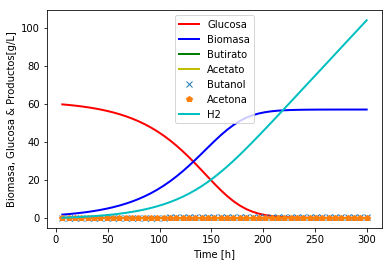

In [5]:
plt.plot(time[1:600],Glu_path,'r',linewidth=2,label='Glucosa')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='Biomasa')
plt.plot(time[1:600],But_path,'g',linewidth=2,label="Butirato")
plt.plot(time[1:600],Act_path,'y',linewidth=2,label='Acetato')
plt.plot(time[1:600],Bth_path,'x',linewidth=2,label='Butanol')
plt.plot(time[1:600],Acn_path,'p',linewidth=2,label='Acetona')
plt.plot(time[1:600],H2_path,'c',linewidth=2,label='H2')
plt.legend()
plt.ylabel('Biomasa, Glucosa & Productos[g/L]')
plt.xlabel('Time [h]')
plt.show()

In [6]:
solution = model.optimize()

model.summary()

IN FLUXES           OUT FLUXES         OBJECTIVES
------------------  -----------------  -----------------
cpd00067_e  10      cpd11640_e  5.14   Biomass  1.37e-06
cpd00013_e   0.959  cpd00001_e  1.78
                    cpd00528_e  0.479


In [7]:
print[Glu_path]

[[59.740357717087505, 59.439731589634945, 59.091867595854595, 58.689633628000934, 58.22492389510507, 57.68856364807464, 57.07021950375741, 56.35832311593002, 55.54001927232676, 54.60115389955548, 53.526323171469045, 52.29901216728238, 50.90186045854056, 49.31710255318547, 47.52724277784045, 45.516035567517676, 43.269850352873014, 40.779499789953675, 38.04259134760224, 35.066409629804795, 31.871227178824082, 28.49374559014586, 24.99006060295239, 21.43712993219513, 17.931296968510846, 14.582260345709944, 11.501472623346183, 8.785815555390062, 6.500385432947664, 4.666717234231244, 3.262026406253419, 2.2300741083526563, 1.4982874558080106, 0.993685773025499, 0.6529658239035667, 0.4263406539739589, 0.27717047555013613, 0.1796754837183137, 0.11625426847155251, 0.07512628393803977, 0.04850936077456759, 0.03130636596139042, 0.02019729272814731, 0.013027434919952608, 0.00840162860674283, 0.005417869729994442, 0.003493559628878682, 0.0022526376006020005, 0.0014524590587622274]]


In [8]:
0.00807479921655957

0.00807479921655957